In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mylibrary.nnlib as tnn
import copy

## Making Class for Soft But Hard Decision Tree - Dynamic Building/End2End

In [2]:
class LeafNode(object):
    
    def __init__(self, parent, constant=None):
        self.parent = parent
        self.constant = tnn.BiasLayer(self.parent.output_dim,
                                      bias=copy.deepcopy(constant),
                                      optimizer=self.parent.optimizer)
        self.error = None
        self.mask = None
        self.m = None
        
    def forward(self, inputs, mask):
        self.mask = mask
        self.m = np.count_nonzero(mask)
        out = np.zeros(shape=(inputs.shape[0], self.parent.output_dim))
        return self.constant.forward(out)*self.mask
    
    def backward(self, del_outputs):
        del_out = del_outputs*self.mask
        self.constant.backward(del_out)

        if self.m==0:return del_outputs
        
        self.error = (del_out**2).sum()/self.m
        return del_outputs
    
    def update(self):
        self.constant.update()
        
    def get_maximum_error_node(self):
        return self
    
    def print_tree(self, depth):
        print(f"{'|     '*depth}Leaf:({depth})")
        return
    
class DecisionNode(object):
    
    def __init__(self, input_dim, output_dim, optimizer):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.optimizer = optimizer
        
        self.node0 = None
        self.node1 = None
        self.linear = tnn.LinearLayer(input_dim, output_dim, optimizer=optimizer)
        self.linear.weights *= 0
        self.sigmoid = tnn.Sigmoid()
        
        self.mask = None
        self.out0 = None
        self.out1 = None
        
    def forward(self, inputs, mask=None):
        if mask is None:mask = np.ones(shape=(inputs.shape[0], 1))
        
        self.mask = mask
        
        lout = self.linear.forward(inputs)
        self.sigmoid.forward(lout)
        
        mask = (lout>0).astype(lout.dtype)
        self.out0 = self.node0.forward(inputs, self.mask*mask)
        self.out1 = self.node1.forward(inputs, self.mask*(1-mask))
        
        return self.out0 + self.out1
    
    def backward(self, del_outputs):
        
        self.node0.backward(del_outputs)
        self.node1.backward(del_outputs)
        
        del_out = del_outputs.mean(axis=1, keepdims=True)*self.mask
        self.linear.backward(self.sigmoid.backward(del_out))
        
        return del_outputs
    
    def update(self):
        self.linear.update()
        self.node0.update()
        self.node1.update()
        
    def create_child(self, depth):
        if depth > 1:
            self.node0 = DecisionNode(self.input_dim, self.output_dim, self.optimizer)
            self.node1 = DecisionNode(self.input_dim, self.output_dim, self.optimizer)
            self.node0.create_child(depth-1)
            self.node1.create_child(depth-1)
        else:
            self.node0 = LeafNode(self)
            self.node1 = LeafNode(self)
            
    def get_maximum_error_node(self):
        n0 = self.node0.get_maximum_error_node()
        n1 = self.node1.get_maximum_error_node()
        if n0.error > n1.error:
            return n0
        else:
            return n1
        
    def print_tree(self, depth=0):
        print(f"{'|     '*depth}DN:({depth})")
        self.node0.print_tree(depth+1)
        self.node1.print_tree(depth+1)

## 1D regression

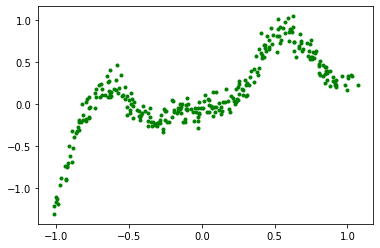

In [3]:
x = np.linspace(0,1,300)
noise = np.random.normal(0,0.02, x.shape)
x = x + noise
x = np.sort(x)

y= (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
noise = np.random.normal(0,0.1, x.shape)
y = y + noise

x = x*2
x = x - x.mean() # good practice to zero-center x in linear mapping
xx = x.reshape(-1,1)
yy = y.reshape(-1,1)

%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.show()

In [4]:
def convert_leaf_to_decision_node(node):
    parent = node.parent
    const = copy.deepcopy(node.constant.bias)

    
    dn = DecisionNode(parent.input_dim, parent.output_dim, parent.optimizer)
    dn.node0 = LeafNode(dn, const)
    dn.node1 = LeafNode(dn, const)
    if parent.node0 is node:
        del parent.node0
        parent.node0 = dn
    elif parent.node1 is node:
        del parent.node1
        parent.node1 = dn
    else:
        print(parent.node0, parent.node1, node)
        print("Error occoured -- Problem in Algorithm")
    return

def add_node_to_tree(tree):
    try:
        node = tree.get_maximum_error_node()
        convert_leaf_to_decision_node(node)
    except:
        print("Error occoured while converting leaf node to decision Node")
    return

In [5]:
optimizer = tnn.Adam()
hdt = DecisionNode(1, 1, optimizer)
hdt.create_child(depth=4)

In [6]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111)

for epoch in range(100000):
    yout = hdt.forward(xx)
    dy = yout - yy
    dx = hdt.backward(dy)
    hdt.update()
    
    if epoch%100 == 0:
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        ax.scatter(x, y, marker='.', color='g')
        ax.scatter(x, yout.reshape(-1), color='r', marker='.')

        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.19488818381589437


100 Error =  0.12575089640898904


200 Error =  0.10836739078654611


300 Error =  0.093545201028514


400 Error =  0.08814034794483559


500 Error =  0.07805890028123207


600 Error =  0.059979574636658955


700 Error =  0.05732664765144804


800 Error =  0.057317495621839


900 Error =  0.05383047253331115


1000 Error =  0.050234994363730245


1100 Error =  0.047680843938667256


1200 Error =  0.04609912503638513


1300 Error =  0.04322830867173431


1400 Error =  0.043573924067067435


TclError: invalid command name "."

In [39]:
add_node_to_tree(hdt)

In [40]:
hdt.print_tree()

DN:(0)
|     DN:(1)
|     |     DN:(2)
|     |     |     DN:(3)
|     |     |     |     Leaf:(4)
|     |     |     |     Leaf:(4)
|     |     |     DN:(3)
|     |     |     |     Leaf:(4)
|     |     |     |     DN:(4)
|     |     |     |     |     Leaf:(5)
|     |     |     |     |     Leaf:(5)
|     |     DN:(2)
|     |     |     DN:(3)
|     |     |     |     Leaf:(4)
|     |     |     |     Leaf:(4)
|     |     |     DN:(3)
|     |     |     |     Leaf:(4)
|     |     |     |     Leaf:(4)
|     DN:(1)
|     |     DN:(2)
|     |     |     DN:(3)
|     |     |     |     Leaf:(4)
|     |     |     |     Leaf:(4)
|     |     |     DN:(3)
|     |     |     |     Leaf:(4)
|     |     |     |     Leaf:(4)
|     |     DN:(2)
|     |     |     DN:(3)
|     |     |     |     Leaf:(4)
|     |     |     |     Leaf:(4)
|     |     |     DN:(3)
|     |     |     |     Leaf:(4)
|     |     |     |     Leaf:(4)


## On 2D dataset

In [41]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)
% matplotlib tk

In [42]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

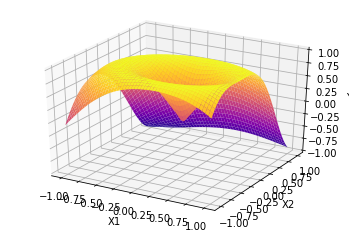

In [43]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.scatter(X1, X2, Y)
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [44]:
xx = np.c_[x1, x2]
yy = Y.reshape(-1,1)

## Building Decision Tree

In [45]:
optimizer = tnn.Adam()
hdt = DecisionNode(2, 1, optimizer)
hdt.create_child(depth=1)

In [88]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')

for epoch in range(100000):

    yout = hdt.forward(xx)
    dy = yout - yy
    dx = hdt.backward(dy)
    hdt.update()
    
    if epoch%100 == 0:
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.019344529234545906


100 Error =  0.018966756303153576


200 Error =  0.01884305823768955


300 Error =  0.01913894697269316


400 Error =  0.018765139630466166


500 Error =  0.018585620585254127


600 Error =  0.018673975390907482


700 Error =  0.018595054632385262


800 Error =  0.018900319353229077


900 Error =  0.018828633238770327


1000 Error =  0.018811219624238585


1100 Error =  0.018878491748848994


TclError: invalid command name "pyimage254"

In [86]:
add_node_to_tree(hdt)

In [87]:
hdt.print_tree()

DN:(0)
     DN:(1)
          DN:(2)
               DN:(3)
                    Leaf:(4)
                    DN:(4)
                         DN:(5)
                              Leaf:(6)
                              Leaf:(6)
                         DN:(5)
                              Leaf:(6)
                              DN:(6)
                                   Leaf:(7)
                                   Leaf:(7)
               Leaf:(3)
          DN:(2)
               DN:(3)
                    DN:(4)
                         Leaf:(5)
                         Leaf:(5)
                    DN:(4)
                         DN:(5)
                              DN:(6)
                                   Leaf:(7)
                                   Leaf:(7)
                              DN:(6)
                                   Leaf:(7)
                                   Leaf:(7)
                         Leaf:(5)
               Leaf:(3)
     Leaf:(1)
